# <center><b>CS5062 (Machine Learning) Assignment II: Deep Recurrent Neural Network for Sentiment Classification</b></center>


#### Accessing Google Drive


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/CS5062ML: Sentiment Analysis

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/CS5062ML: Sentiment Analysis


#### Importing libraries

In [0]:
%matplotlib inline
%tensorflow_version 1.x

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from scipy.spatial.distance import cdist
import re, random, math, collections, itertools
from sklearn.metrics import classification_report, confusion_matrix
import json

# keras modules
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#import tflearn
#from tflearn.datasets import imdb

### Reading the Rotten Tomatoes and Nokia review texts

In [0]:
def readFiles():
    '''
    Reads the samples within each dataset, splits them and saves them to a list. Populates
    the sentiment dictionary with positive and negative sentiments.
    
        Args:
            
        Returns:
            sentimentDictionary(dict): the lookup dictionary
            pos_rt(list): the positive samples from Rotten Tomatoes
            neg_rt(list): the negative samples from Rotten Tomatoes
            pos_nokia(list): the positive samples from the Nokia dataset 
            neg_nokia(list): the negative samples from the Nokia dataset
    '''
    sentimentDictionary = dict()
    #reading pre-labeled input and splitting into lines
    posSentences = open('rt-polarity.pos', 'r', encoding="ISO-8859-1")
    pos_rt = re.split(r'\n', posSentences.read())

    negSentences = open('rt-polarity.neg', 'r', encoding="ISO-8859-1")
    neg_rt = re.split(r'\n', negSentences.read())

    posSentencesNokia = open('nokia-pos.txt', 'r')
    pos_nokia = re.split(r'\n', posSentencesNokia.read())

    negSentencesNokia = open('nokia-neg.txt', 'r', encoding="ISO-8859-1")
    neg_nokia = re.split(r'\n', negSentencesNokia.read())
 
    posDictionary = open('positive-words.txt', 'r', encoding="ISO-8859-1")
    posWordList = posDictionary.readlines()
    posWordList = [line.strip() for line in posWordList if not line.startswith(";") and not line == '\n']
    #posWordList = re.findall(r"[a-z\-]+", posDictionary.read())

    negDictionary = open('negative-words.txt', 'r', encoding="ISO-8859-1")
    negWordList = negDictionary.readlines()
    negWordList = [line.strip() for line in negWordList if not line.startswith(";") and not line == '\n']
    #negWordList = re.findall(r"[a-z\-]+", negDictionary.read())

    for i in posWordList:
        sentimentDictionary[i] = 1
    for i in negWordList:
        sentimentDictionary[i] = -1

    return sentimentDictionary, pos_rt, neg_rt, pos_nokia, neg_nokia

In [0]:
sent_dict, pos_rt, neg_rt, pos_nokia, neg_nokia = readFiles()

In [0]:
print('Print total positive words in sentiment dictionary:', sum([v == 1 for v in sent_dict.values()]))
print('Print total negative words in sentiment dictionary:', sum([v == -1 for v in sent_dict.values()]))

Print total positive words in sentiment dictionary: 2003
Print total negative words in sentiment dictionary: 4783


In [0]:
print(len(pos_rt), len(neg_rt))

5332 5332


In [0]:
pos_nokia[3]

'the speaker phone is very functional and i use it in the car , very audible even with freeway noise . '

In [0]:
print(len(pos_nokia), len(neg_nokia))

194 80


#### Concatenate the Rotten Tomatoes data and create the labels

In [0]:
def create_dataset(pos_rt, neg_rt):
  '''
    Concatenates the positive and negative samples into one dataset and creates a list of labels.
    
        Args:
            pos_rt(list): the positive samples from the dataset
            neg_rt(list): the negative samples from the dataset
        Returns:
            rt_data(list): the list of concatenated samples
            rt_labels(list): the list of annotations for each sample
  '''
  rt_labels = list()
  rt_data = pos_rt + neg_rt

  for i in range(len(pos_rt)):
    rt_labels.append(1)
  
  for i in range(len(neg_rt)):
    rt_labels.append(0)

  return rt_data, rt_labels

In [0]:
rt_data, rt_labels = create_dataset(pos_rt, neg_rt)

In [0]:
print(sum(v == 1 for v in rt_labels))
print(sum(v == 0 for v in rt_labels))

5332
5332


In [0]:
print(len(rt_data))

10664


#### Preprocess the sentences

In [0]:
tokenizer = Tokenizer(num_words=None)

In [0]:
%%time
tokenizer.fit_on_texts(rt_data)

CPU times: user 300 ms, sys: 3.87 ms, total: 303 ms
Wall time: 310 ms


In [0]:
top_words = tokenizer.word_counts
top_words = sorted(top_words.items(), key=lambda kv: kv[1], reverse=True)[:20]

In [0]:
print(top_words)

[('the', 10192), ('a', 7335), ('and', 6263), ('of', 6147), ('to', 4275), ('is', 3383), ('in', 2671), ('that', 2472), ('it', 2289), ('as', 1808), ('but', 1641), ('with', 1562), ('film', 1457), ('for', 1455), ('this', 1442), ('its', 1338), ('an', 1326), ('movie', 1324), ("it's", 1127), ('be', 948)]


In [0]:
print('Number of unique words indexed:', len(tokenizer.word_index))

Number of unique words indexed: 19498


In [0]:
rt_data_sequences = tokenizer.texts_to_sequences(rt_data)

#### Split the data

In [0]:
test_size = int(0.1 * len(rt_data_sequences))
rt_data_np = np.vstack((rt_data_sequences, rt_labels)).T
np.random.shuffle(rt_data_np)
rt_features_train = list(rt_data_np[:, 0][:-test_size])
rt_labels_train = list(rt_data_np[:, 1][:-test_size])
rt_features_test = list(rt_data_np[:, 0][-test_size:])
rt_labels_test = list(rt_data_np[:, 1][-test_size:])

In [0]:
print(rt_data_np.shape, len(rt_features_train), len(rt_features_test), len(rt_labels_train), len(rt_labels_test))

(10664, 2) 9598 1066 9598 1066


In [0]:
print(rt_features_train[:3], rt_labels_train[:3])

[[3622, 874, 296, 7, 1322, 3, 4302, 11756, 11757, 674, 159, 83, 2747, 6138, 10, 2, 235, 682, 4, 133, 311, 8133, 3, 11758], [2, 1546, 8118, 173, 4, 85, 2698, 3, 8119], [9, 78, 23, 20, 296, 640, 11, 216, 259, 49, 38, 9, 6, 640, 11, 9, 75, 14, 25, 4, 1, 50, 2998, 350, 3, 503, 12396, 31, 1, 95, 712, 215, 7, 2, 89]] [1, 1, 1]


#### Padding and selecting the maximum number of tokens

In [0]:
def pad_tokenized_data(train_tokens, test_tokens, sigma=2, pad_type='pre'):
  '''
    Calculates a percentage of the dataset to keep based on sigma to eliminate long sequences of tokens.
    Pads the remaining sentences with 0 to match the sequence with the maximum length.
    
        Args:
            train_tokens(list): the tokenized list of training sentences
            test_tokens(list): the tokenized list of test sentences
            sigma(int): the weight value for the standard deviation, which affects the number of tokens to keep
            pad_type(str): 'pre' - pads the sentences with 0 before the initial token values;
                           'post' - pads the sentences with 0 after the initial token values;
        Returns:
            max_tokens(int): the calculated maximum number of tokens left in the dataset
            train_pad(list): the padded list of preprocessed training tokens
            test_pad(list): the padded list of preprocessed test tokens
  '''
  num_tokens = [len(tokens) for tokens in train_tokens]
  num_tokens += [len(tokens) for tokens in test_tokens]
  num_tokens = np.array(num_tokens)
  print('Average number of tokens:', np.mean(num_tokens))
  print('Max number of tokens:', np.max(num_tokens))
  max_tokens = np.mean(num_tokens) + sigma * np.std(num_tokens)
  max_tokens = int(max_tokens)
  # limit the max number of tokens in a sentence by removing long examples
  print('Max number of allowed tokens in the network:', max_tokens)
  print('% of dataset to keep:', np.sum(num_tokens < max_tokens) / len(num_tokens))

  train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding=pad_type, truncating=pad_type)
  test_pad = pad_sequences(test_tokens, maxlen=max_tokens,
                            padding=pad_type, truncating=pad_type)
  
  print('Padded shapes: Train({}), Test({})'.format(train_pad.shape, test_pad.shape))

  return max_tokens, train_pad, test_pad

In [0]:
max_tokens, rt_features_train_pad, rt_features_test_pad = pad_tokenized_data(rt_features_train, rt_features_test)

Average number of tokens: 18.888034508627157
Max number of tokens: 51
Max number of allowed tokens in the network: 36
% of dataset to keep: 0.9629594898724682
Padded shapes: Train((9598, 36)), Test((1066, 36))


#### Get the sentences from the word tokens

In [0]:
def get_sentence(tokens, tokenizer):
  '''
    Inverse-maps the tokenized sentence to its original counterpart using the Tokenizer class.
    
        Args:
            tokens(np.array): an input array of tokens
            tokenizer(Tokenizer): the fit Tokenizer object from Keras
        Returns:
            text(str): the original sentence
  '''
  idx = tokenizer.word_index
  inverse_map = dict(zip(idx.values(), idx.keys()))
  sentence = list()
  # Map from tokens back to words.
  for token in tokens:
    if token != 0:
      sentence.append(inverse_map[token])
  
  # Concatenate all words.
  text = " ".join(sentence)

  return text

In [0]:
print('Sentence: ', get_sentence(np.array(rt_features_train[1]), tokenizer))
print('Label: ', rt_labels_train[1])

Sentence:  a wonderfully loopy tale of love longing and voting
Label:  1


#### Build the RNN

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model_checkpointer = ModelCheckpoint('./best_rnn.h5',
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

In [0]:
def build_sentiment_rnn(tokenizer, max_tokens, emb_size=8):
  '''
    Creates a 3-layer Recurrent Neural Network with GRU units.
    
        Args:
            tokenizer(Tokenizer): the fit Tokenizer object from Keras
            max_tokens(int): the calculated maximum number of tokens left in the dataset
            emb_size(int): the width of the embedding matrix used for repeating the embeddings across multiple dimensions.
        Returns:
            model(Sequential): the trained Keras model
  '''
  model = Sequential()
  model.add(Embedding(input_dim=len(tokenizer.word_counts), output_dim=emb_size, input_length=max_tokens, name='emb'))
  model.add(GRU(units=16, return_sequences=True))
  model.add(GRU(units=8, return_sequences=True))
  model.add(GRU(units=4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])
  print(model.summary())
  return model

In [0]:
rnn_model = build_sentiment_rnn(tokenizer, max_tokens)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              (None, 36, 8)             155984    
_________________________________________________________________
gru_15 (GRU)                 (None, 36, 16)            1200      
_________________________________________________________________
gru_16 (GRU)                 (None, 36, 8)             600       
_________________________________________________________________
gru_17 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 157,945
Trainable params: 157,945
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
def save_hist(filename, history):
  '''
    Helper-function for saving the model history.
    
        Args:
            filename(str): the output filename.
            history(str): a stringified JSON object
        Returns:
  '''
    with open(filename, "w") as write_file:
        json.dump(history, write_file)
def load_hist(filename):
  '''
    Helper-function for loading the model history.
    
        Args:
            filename(str): the input filename.
        Returns:
            train_hist(JSON): a JSON object containing the model history.
  '''
    with open(filename, 'r', encoding='utf-8') as read_file:
        train_hist = json.loads(read_file.read())
        return train_hist

In [0]:
%%time
#rnn_model.load_weights('best_rnn.h5')
history = rnn_model.fit(rt_features_train_pad, rt_labels_train,
          validation_split=0.05, epochs=10, batch_size=32,
          callbacks=[model_checkpointer, learning_rate_reduction])

Train on 9118 samples, validate on 480 samples
Epoch 1/10
9088/9118 [============================>.] - ETA: 0s - loss: 0.6532 - acc: 0.6057
Epoch 00001: val_loss improved from inf to 0.57245, saving model to ./best_rnn.h5
9118/9118 [==============================] - 54s 6ms/sample - loss: 0.6528 - acc: 0.6063 - val_loss: 0.5724 - val_acc: 0.6979
Epoch 2/10
9088/9118 [============================>.] - ETA: 0s - loss: 0.4684 - acc: 0.7827
Epoch 00002: val_loss improved from 0.57245 to 0.48890, saving model to ./best_rnn.h5
9118/9118 [==============================] - 48s 5ms/sample - loss: 0.4684 - acc: 0.7825 - val_loss: 0.4889 - val_acc: 0.7646
Epoch 3/10
9088/9118 [============================>.] - ETA: 0s - loss: 0.3572 - acc: 0.8485
Epoch 00003: val_loss improved from 0.48890 to 0.47282, saving model to ./best_rnn.h5
9118/9118 [==============================] - 48s 5ms/sample - loss: 0.3578 - acc: 0.8483 - val_loss: 0.4728 - val_acc: 0.7708
Epoch 4/10
9088/9118 [====================

In [0]:
save_hist('./best_rnn.json', str(history.history))
#history = load_hist('./best_rnn.json')

#### Evaluation

In [0]:
def plot_learning_curves(history):
  '''
    Helper-function for plotting the model learning curves.
    
        Args:
            history(dict): the dictionary containing the performance metrics over epochs
        Returns:
  '''
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

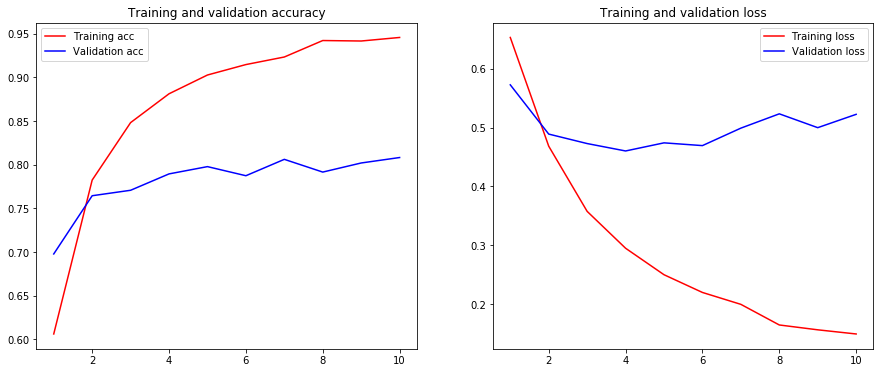

In [0]:
plot_learning_curves(history)

In [0]:
def plot_confusion_matrix_and_report(features, labels, model, classes=['negative', 'positive']):
    '''
    Helper-function for plotting the confusion matrix and printing the performance metrics.
    
        Args:
            features(list): the test input sentences
            labels(list): the annotations for the input sentences
            model(Sequential): the trained Keras model
            classes(list): the list of class names to display
        Returns:
    '''
    test_pred = model.predict(features)
    test_pred = test_pred.T[0]
    print("Classification report")
    cls_pred = np.int32(np.array([1.0 if p>0.5 else 0.0 for p in test_pred]))
    cls_true = np.int32(np.array(labels))
    print(classification_report(cls_true, cls_pred, target_names=classes))    

    # Loss function and accuracy
    test_res = model.evaluate(features, labels, verbose=1)
    print('Loss: {}, Accuracy: {}'.format(test_res[0], test_res[1]))
    
    # Confusion Matrix
    print('Confusion matrix.')
    
    cm_test = confusion_matrix(cls_true, cls_pred)
    print(cm_test)
    print()
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm_test, cmap=plt.get_cmap('gray'))
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Example errors
    print('First 10 Errors')
    incorrect = np.where(cls_pred != cls_true)
    incorrect = incorrect[0]
    for i in range(10):
      if i > (len(incorrect) - 1):
        break
      idx = incorrect[i]
      print('Sample: ', i)
      print('Sentence: ', get_sentence(np.array(features[idx]), tokenizer))
      print('True Label:{}, Predicted Label:{}'.format(labels[idx], cls_pred[idx]))
      print()
    
    

Classification report
              precision    recall  f1-score   support

    negative       0.80      0.75      0.77       516
    positive       0.78      0.83      0.80       550

    accuracy                           0.79      1066
   macro avg       0.79      0.79      0.79      1066
weighted avg       0.79      0.79      0.79      1066

1066/1066 [==============================] - 1s 1ms/sample - loss: 0.6179 - acc: 0.7880
Loss: 0.6178504592034875, Accuracy: 0.7879924774169922
Confusion matrix.
[[386 130]
 [ 96 454]]



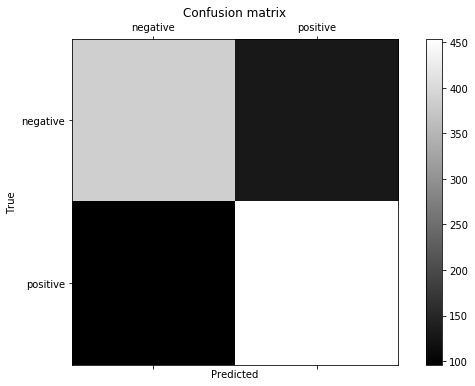

First 10 Errors
Sample:  0
Sentence:  returning director rob minkoff and screenwriter bruce joel rubin have done a fine job of updating white's dry wit to a new age
True Label:1, Predicted Label:0

Sample:  1
Sentence:  it wraps up a classic mother daughter struggle in recycled paper with a shiny new bow and while the audience can tell it's not all new at least it looks pretty
True Label:0, Predicted Label:1

Sample:  2
Sentence:  there's a thin line between likably old fashioned and fuddy duddy and the count of monte cristo never quite settles on either side
True Label:0, Predicted Label:1

Sample:  3
Sentence:  if i spy were funny enough or exciting enough then it would be fairly simple to forgive the financial extortion it's trying to reap from the moviegoing public
True Label:0, Predicted Label:1

Sample:  4
Sentence:  the paradiso's rusted out ruin and ultimate collapse during the film's final restored thirdemotionally belittle a cinema classic sometimes shorter is better
True La

In [0]:
plot_confusion_matrix_and_report(rt_features_test_pad, rt_labels_test, rnn_model)

#### Predict new samples

In [0]:
def predict_new_samples(samples, tokenizer, model, max_tokens=max_tokens, pad_type='pre'):
  '''
    Helper-function for running new samples for prediction.
    
        Args:
            samples(list): the list of input samples to predict
            tokenizer(Tokenizer): the fit Keras Tokenizer object
            model(Sequential): the trained Keras RNN model
            max_tokens(int): the calculated maximum number of tokens allowed for the model
            pad_type(str): 'pre' - pads the sentences with 0 before the initial token values;
                           'post' - pads the sentences with 0 after the initial token values;

        Returns:
    '''
  tokens = tokenizer.texts_to_sequences(samples)
  tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad_type, truncating=pad_type)
  test_pred = model.predict(tokens_pad)
  test_pred = test_pred.T[0]
  cls_pred = np.int32(np.array([1.0 if p>0.5 else 0.0 for p in test_pred]))
  for i in range(len(samples)):
    print('Sample:{}, Prediction:{}'.format(samples[i], cls_pred[i]))

In [0]:
samples = [
           'This movie was extremely bad.',
           'It was decent, I guess..',
           'Fantastic acting, main character is guaranteed an Oscar nomination!!',
           'The ending was really emotional, left me in tears.',
           'A romantic comedy that operates by the rules of its own self-contained universe.', #true - positive
           'The film is faithful to what one presumes are the book\'s twin premises -- that we become who we are on the backs of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious commodity no matter how old you are.', # positive
           'Its scenes and sensibility are all more than familiar , but it exudes a kind of nostalgic spy-movie charm and , at the same time , is so fresh and free of the usual thriller nonsense that it all seems to be happening for the first time.', # positive
           'Greene delivers a typically solid performance in a role that is a bit of a departure from the noble characters he has played in the past , and he is matched by schweig , who carries the film on his broad , handsome shoulders.', # positive
           'Superbly mixes together a political and horror story in this shocker of a postcolonial supernatural fable.', # positive
           'Motherless Brooklyn is so messy, confusing and pointless that you don\'t know what\'s going on half the time, and couldn\'t care less.', # negative
           'Edward Norton crafts an elegant neo-noir in Motherless Brooklyn. The intricate character study not only captures the depth of the evolution happening in the years following World War II, but telling an interesting an entertaining story.' # positive
]

In [0]:
predict_new_samples(samples, tokenizer, rnn_model)

Sample:This movie was extremely bad., Prediction:0
Sample:It was decent, I guess.., Prediction:0
Sample:Fantastic acting, main character is guaranteed an Oscar nomination!!, Prediction:1
Sample:The ending was really emotional, left me in tears., Prediction:0
Sample:A romantic comedy that operates by the rules of its own self-contained universe., Prediction:0
Sample:The film is faithful to what one presumes are the book's twin premises -- that we become who we are on the backs of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious commodity no matter how old you are., Prediction:1
Sample:Its scenes and sensibility are all more than familiar , but it exudes a kind of nostalgic spy-movie charm and , at the same time , is so fresh and free of the usual thriller nonsense that it all seems to be happening for the first time., Prediction:1
Sample:Greene delivers a typically solid performance in a role that is a bit of a departure from the nobl

### Nokia dataset

#### Preprocessing

In [0]:
nk_data, nk_labels = create_dataset(pos_nokia, neg_nokia)

In [0]:
print(sum(v == 1 for v in nk_labels))
print(sum(v == 0 for v in nk_labels))

194
80


In [0]:
%%time
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(nk_data)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 14.7 ms


In [0]:
top_words = tokenizer.word_counts
top_words = sorted(top_words.items(), key=lambda kv: kv[1], reverse=True)[:20]
print(top_words)

[('the', 260), ('is', 139), ('phone', 126), ('i', 116), ('and', 105), ('to', 93), ('it', 92), ('a', 92), ('this', 79), ('with', 54), ('you', 50), ('in', 49), ('that', 48), ('of', 45), ('are', 41), ('have', 40), ('very', 38), ('but', 35), ('not', 33), ('on', 33)]


In [0]:
nk_data_sequences = tokenizer.texts_to_sequences(nk_data)

In [0]:
test_size = int(0.1 * len(nk_data_sequences))
nk_data_np = np.vstack((nk_data_sequences, nk_labels)).T
np.random.shuffle(nk_data_np)
nk_features_train = list(nk_data_np[:, 0][:-test_size])
nk_labels_train = list(nk_data_np[:, 1][:-test_size])
nk_features_test = list(nk_data_np[:, 0][-test_size:])
nk_labels_test = list(nk_data_np[:, 1][-test_size:])

In [0]:
print(nk_data_np.shape, len(nk_features_train), len(nk_features_test), len(nk_labels_train), len(nk_labels_test))

(274, 2) 247 27 247 27


In [0]:
max_tokens, nk_features_train_pad, nk_features_test_pad = pad_tokenized_data(nk_features_train, nk_features_test)

Average number of tokens: 15.824817518248175
Max number of tokens: 59
Max number of allowed tokens in the network: 35
% of dataset to keep: 0.9525547445255474
Padded shapes: Train((247, 35)), Test((27, 35))


#### Training

In [0]:
model_checkpointer = ModelCheckpoint('./best_rnn_nk.h5',
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

In [0]:
rnn_model = build_sentiment_rnn(tokenizer, max_tokens)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              (None, 35, 8)             8000      
_________________________________________________________________
gru_18 (GRU)                 (None, 35, 16)            1200      
_________________________________________________________________
gru_19 (GRU)                 (None, 35, 8)             600       
_________________________________________________________________
gru_20 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 9,961
Trainable params: 9,961
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
# rnn_model.load_weights('best_rnn_nk.h5')
history = rnn_model.fit(nk_features_train_pad, nk_labels_train,
          validation_split=0.05, epochs=100, batch_size=32,
          callbacks=[model_checkpointer, learning_rate_reduction])

Train on 234 samples, validate on 13 samples
Epoch 1/100
224/234 [===========================>..] - ETA: 0s - loss: 0.6806 - acc: 0.6741
Epoch 00001: val_loss improved from inf to 0.67366, saving model to ./best_rnn_nk.h5
234/234 [==============================] - 9s 38ms/sample - loss: 0.6783 - acc: 0.6880 - val_loss: 0.6737 - val_acc: 0.6154
Epoch 2/100
224/234 [===========================>..] - ETA: 0s - loss: 0.6493 - acc: 0.7143
Epoch 00002: val_loss improved from 0.67366 to 0.66183, saving model to ./best_rnn_nk.h5
234/234 [==============================] - 1s 6ms/sample - loss: 0.6475 - acc: 0.7179 - val_loss: 0.6618 - val_acc: 0.6154
Epoch 3/100
224/234 [===========================>..] - ETA: 0s - loss: 0.6185 - acc: 0.7188
Epoch 00003: val_loss improved from 0.66183 to 0.65456, saving model to ./best_rnn_nk.h5
234/234 [==============================] - 1s 6ms/sample - loss: 0.6184 - acc: 0.7179 - val_loss: 0.6546 - val_acc: 0.6154
Epoch 4/100
224/234 [=========================

In [0]:
save_hist('./best_rnn_nk.json', str(history.history))
#history = load_hist('./best_rnn_nk.json')

#### Evaluation

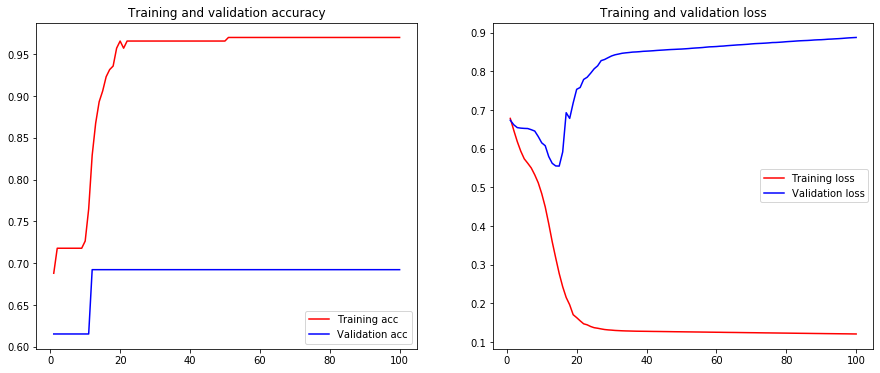

In [0]:
plot_learning_curves(history)

Classification report
              precision    recall  f1-score   support

    negative       0.80      0.44      0.57         9
    positive       0.77      0.94      0.85        18

    accuracy                           0.78        27
   macro avg       0.79      0.69      0.71        27
weighted avg       0.78      0.78      0.76        27

27/27 [==============================] - 0s 1ms/sample - loss: 0.5004 - acc: 0.7778
Loss: 0.5004013776779175, Accuracy: 0.7777777910232544
Confusion matrix.
[[ 4  5]
 [ 1 17]]



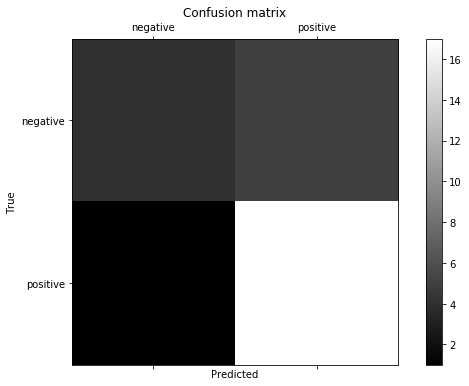

First 10 Errors
Sample:  0
Sentence:  family plan indeed very easy to switch to the family plan and one came with a broken headphone can hear but cannot be heard and one died today after less than two weeks of use
True Label:0, Predicted Label:1

Sample:  1
Sentence:  the voice quality is very good and it gets great reception that is in places where you get t mobile coverage which is not that good see below
True Label:1, Predicted Label:0

Sample:  2
Sentence:  finally i reiterate my thumbs down rating for t mobile as a carrier
True Label:0, Predicted Label:1

Sample:  3
Sentence:  although i find it more convenient to use 1 touch dialing this phone does not have voice dialing
True Label:0, Predicted Label:1

Sample:  4
Sentence:  its quiet
True Label:0, Predicted Label:1

Sample:  5
Sentence:  the fact that the 0 key is the space key for text input is a bit confusing as many phones use the key instead
True Label:0, Predicted Label:1



In [0]:
plot_confusion_matrix_and_report(nk_features_test_pad, nk_labels_test, rnn_model)

In [0]:
samples = [
           'My charger isn\'t working.',
           'Good camera quality.',
           'Over the years I\'ve grown quite fond of the OnePlus alert slider on the side as it\'s a great alternative to the iPhone’s mute switch.',
           'Don’t buy the Samsung Galaxy Fold. It’s almost strange to have to write those words explicitly because after everything that has happened with this phone / tablet hybrid, you’d like to think that everybody would know the score already.',
           'This one hasn’t broken, even after a few weeks of regular use.',
           'The Galaxy Fold forces you to make too many compromises. You have to compromise on durability, on having a phone you can fit in your pocket, and, most of all, on price.',
           'The menu options are uncreative , as you can \'t see a full screen of menu items to pick from ; you have to scroll up and down to find what you \'re looking for ( yes , this is minor , but not when you \'re trying to keep your eye on the road ! )',
           'The first night i got this phone i put it next to me when i went to bed just to listen to my favorite music station and the handset itself doesnt weight anything its too light and feel so comfy with it .'
]

In [0]:
predict_new_samples(samples, tokenizer, rnn_model, max_tokens=max_tokens)

Sample:My charger isn't working., Prediction:1
Sample:Good camera quality., Prediction:1
Sample:Over the years I've grown quite fond of the OnePlus alert slider on the side as it's a great alternative to the iPhone’s mute switch., Prediction:1
Sample:Don’t buy the Samsung Galaxy Fold. It’s almost strange to have to write those words explicitly because after everything that has happened with this phone / tablet hybrid, you’d like to think that everybody would know the score already., Prediction:1
Sample:This one hasn’t broken, even after a few weeks of regular use., Prediction:1
Sample:The Galaxy Fold forces you to make too many compromises. You have to compromise on durability, on having a phone you can fit in your pocket, and, most of all, on price., Prediction:1
Sample:The menu options are uncreative , as you can 't see a full screen of menu items to pick from ; you have to scroll up and down to find what you 're looking for ( yes , this is minor , but not when you 're trying to keep